In [1]:
import os
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn import preprocessing
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error

In [145]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [98]:
train_df['time'].describe()

count    400.000000
mean       3.202330
std        5.265786
min        0.075342
25%        0.504478
50%        1.405072
75%        3.628776
max       41.099969
Name: time, dtype: float64

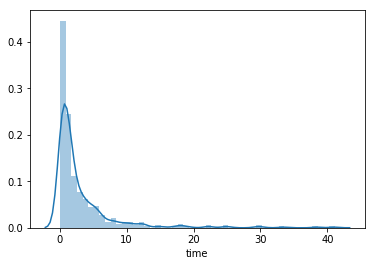

In [37]:
sns.distplot(train_df['time'])

In [38]:
train_df['time'] = np.log1p(train_df['time'])

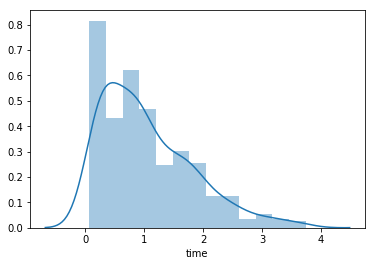

In [39]:
sns.distplot(train_df['time'])

In [40]:
train_df['time'].describe()

count    400.000000
mean       1.051870
std        0.779009
min        0.072638
25%        0.408446
50%        0.877580
75%        1.532285
max        3.740047
Name: time, dtype: float64

In [99]:
train_y = train_df.pop('time')

In [100]:
train_y = train_y.to_frame(name='time')

In [101]:
train_y.head()

,time
0,0.409987
1,3.950953
2,0.368702
3,1.004559
4,0.802800


In [102]:
#combine data
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df,test_df)).reset_index(drop=True)
print('the size of all_data is:{}'.format(all_data.shape))

the size of all_data is:(500, 14)


In [103]:
all_data = all_data.drop(['id'],axis=1)

In [104]:
all_data = all_data.drop(['random_state'],axis=1)

In [105]:
#encode nominal features
label_encoder=[]
encoded_set = np.empty(all_data.shape)
for col in range(all_data.shape[1]):
    encoder=None
    if all_data.iloc[:,col].dtype==object:
        encoder=preprocessing.LabelEncoder()
        tmp = encoder.fit_transform(all_data.iloc[:,col])
        all_data.iloc[:,col] = tmp
    else:  
        encoded_set[:,col]=all_data.iloc[:,col]
    label_encoder.append(encoder)

In [106]:
all_data.head()

,penalty,l1_ratio,alpha,max_iter,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale
0,3,0.304083,0.0001,417,-1,1089,327,4,3,7,0.074798,24.242009
1,1,0.727744,0.0010,578,1,790,373,4,5,7,0.077781,54.626302
2,3,0.745885,0.0100,588,2,428,1198,2,5,6,0.030196,17.999964
3,3,0.474605,0.0010,829,4,877,313,6,5,7,0.057261,82.257222
4,0,0.395049,0.0010,167,2,216,644,8,5,11,0.073728,95.515601


In [107]:
all_data['new'] = all_data.apply(lambda row: row['max_iter'] * row['n_samples']*row['n_features'], axis=1)
all_data.drop(['max_iter'],axis = 1,inplace = True) 
all_data.drop(['n_samples'],axis = 1,inplace = True) 
all_data.drop(['n_features'],axis = 1,inplace = True) 

In [108]:
all_data.shape

(500, 10)

In [109]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [110]:
train.shape,test.shape

((400, 10), (100, 10))

In [111]:
train_np = train.values
train_ynp = train_y.values

In [91]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesRegressor()
clf = clf.fit(train_np,train_ynp)
clf.feature_importances_

array([0.20317101, 0.03382993, 0.02243005, 0.1897038 , 0.0742509 ,
       0.03029175, 0.02761981, 0.04440429, 0.02566224, 0.34863623])

In [135]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler

In [136]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

lasso =Lasso(alpha=.3)
lasso.fit(train_np,train_ynp)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [137]:
names = ["x%s" % i for i in range(1,11)]
ranks = {}

In [139]:
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [140]:
ranks["Lasso"]= rank_to_dict(np.abs(lasso.coef_),names)

In [141]:
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

In [142]:
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

In [143]:
print("\t%s" % "\t".join(methods))
for name in names:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	Mean
x1	1.0	1.0
x2	0.0	0.0
x3	0.0	0.0
x4	0.15	0.15
x5	0.22	0.22
x6	0.0	0.0
x7	0.01	0.01
x8	0.0	0.0
x9	0.0	0.0
x10	0.0	0.0
